# k-Nearest-Neighbors


### Jack Bennetto
#### January 30, 2019

(based on John Bourassa's lecture, based on my lecture in zipfian, based on the lecture from Jonathan Torrez)

## Agenda

#### Morning: kNN

 * Non-parametric models
 * Understanding kNN
 * Scaling
 * Distance metrics
 * Curse of Dimensionality

## Morning Objectives - kNN

* Implement the **kNN** algorithm
* State **common distance metrics** used for kNN
* Describe effect of **varying k**
* Explain importance of **scaling** for kNN

## kNN

Over the next weeks we'll talk about a number of machine learning models. The kNN model is a non-parametric discriminative supervised-learning model used for classification or regression. It's not very good one, but it's a great example to get us started.

**Discussion:** What do all those words mean?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
np.random.seed(3)

Today we'll mostly focus on classification, since it's easier to present kNN that way. The iris dataset is always a good example.

In [2]:
#Load in iris dataset
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]

#Reduce the data down to 2 classes and 2 predictor variables
X = X[y != 0, :2] 

#Add some noise so data points aren't exactly duplicated
X = X + np.random.normal(0, .05, size = X.shape)

#Change Sepal Length from cm to mm to cause scaling issues
X[:,0] = X[:,0] * 10
y = y[y != 0] - 1

In [3]:
#Save some points for later
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .1)

In [4]:
def plot_flower_data(ax, X, y):
    ax.scatter(X[y == 0,0], X[y == 0,1], c = "orange", label = "versicolor")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color = "black", label = "virginica")
    ax.set_xlabel("Sepal Length (mm)")
    ax.set_ylabel("Sepal Width (cm)")
    ax.legend()

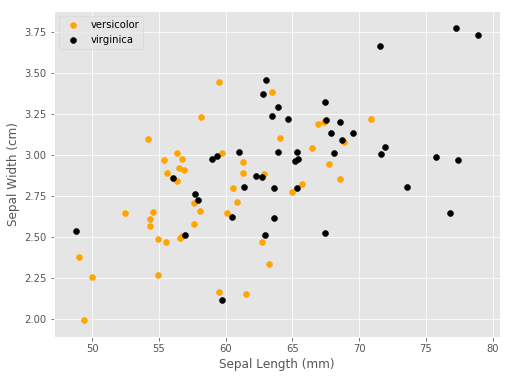

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_flower_data(ax, Xtrain, ytrain)

## What if we get new data? 

In [6]:
Xtest

array([[71.56884576,  3.2535842 ],
       [60.4229167 ,  2.80695552],
       [63.21298337,  2.69254931],
       [61.71264579,  2.89452728],
       [51.3395358 ,  2.45722814],
       [56.98480322,  2.65196124],
       [76.6419871 ,  2.83657329],
       [66.70574919,  2.92267221],
       [67.3239149 ,  3.27198133],
       [72.65501966,  2.92432072]])

## What type of flower are they?

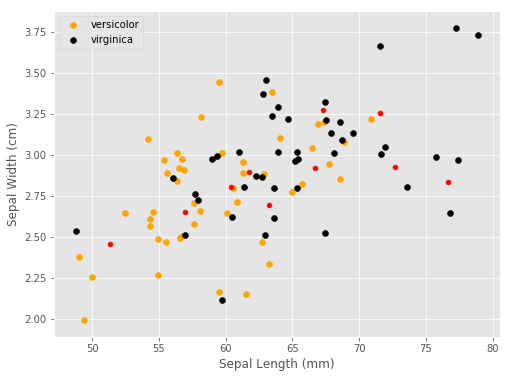

In [12]:
# Plot the new points
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the original data
plot_flower_data(ax, Xtrain, ytrain)

ax.scatter(Xtest[:,0], Xtest[:,1], color = "red", s = 25)

## kNN pseudocode

Class discussion: What do you think this is? Describe both the training and prediction phases.

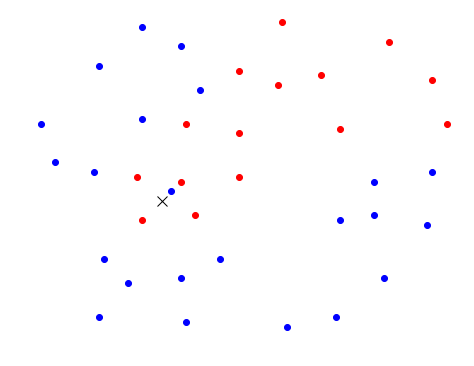

In [13]:
fig, ax = plt.subplots(figsize=(8,8))

a = np.array([[2.1, 3.2, 2.0, 2.9, 4.1, 3.0, 4.1, 6.2, 8.4, 4.1, 4.9, 5.8, 8.1, 5.0, 7.2],
              [3.1, 3.2, 4.0, 3.9, 4.0, 5.1, 4.9, 5.0, 5.1, 6.2, 5.9, 6.1, 6.0, 7.2, 6.8]])
b = np.array([[1.2, 1.8, 3.0, 5.1, 6.1, 1.3, 2.9, 3.7, 7.1, 6.2, 6.9, 8.0, 2.7, 0.3, 1.1, 6.9, 8.1, 0.0, 2.1, 1.2, 3.3, 2.1, 2.9],
              [1.1, 1.8, 1.0, 0.9, 1.1, 2.3, 1.9, 2.3, 1.9, 3.1, 3.2, 3.0, 3.7, 4.3, 4.1, 3.9, 4.1, 5.1, 5.2, 6.3, 5.8, 7.1, 6.7]])
center = np.array([[2.5], [3.5]])
ax.plot(a[0], a[1], 'ro')
ax.plot(b[0], b[1], 'bo')
ax.plot(center[0], center[1], 'kx', ms=10) 
#ax.add_artist(plt.Circle(center, 0.4, fc='None', ec='k', lw=0.5))
#ax.add_artist(plt.Circle(center, 1.0, fc='None', ec='k', lw=0.5))
#ax.add_artist(plt.Circle(center, 2.0, fc='None', ec='k', lw=0.5))
ax.set_aspect('equal')
plt.axis('off')
plt.show()

What do we predict for different values of k?

In [14]:
def plot_mult_decision_boundary(ax, X, y, k, scaled=True, 
                                title='Title', xlabel='xlabel', 
                                ylabel='ylabel', hard_class = True):
    
    """Plot the decision boundary of a kNN classifier.
    
    Builds and fits a sklearn kNN classifier internally.

    X must contain only 2 continuous features.

    Function modeled on sci-kit learn example.

    Parameters
    ----------
    ax: Matplotlib axes object
        The plot to draw the data and boundary on
        
    X: numpy array
        Training data
    
    y: numpy array
        Target labels
    
    k: int
        The number of neighbors that get a vote.
        
    scaled: boolean, optional (default=True)
        If true scales the features, else uses features in original units
    
    title: string, optional (default = 'Title')
        A string for the title of the plot
    
    xlabel: string, optional (default = 'xlabel')
        A string for the label on the x-axis of the plot
    
    ylabel: string, optional (default = 'ylabel')
        A string for the label on the y-axis of the plot
    
    hard_class: boolean, optional (default = True)
        Use hard (deterministic) boundaries vs. soft (probabilistic) boundaries
    

    Returns
    -------
    None
    """
    x_mesh_step_size = 0.1
    y_mesh_step_size = 0.01
    
    #Hard code in colors for classes, one class in red, one in blue
    bg_colors = np.array([np.array([255, 150, 150])/255, np.array([150, 150, 255])/255])
    cmap_light = ListedColormap(bg_colors)
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    #Build a kNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    
    if scaled:
        #Build pipeline to scale features
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X, y)
    else:
        clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = 45, 85
    y_min, y_max = 2, 4
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_mesh_step_size),
                         np.arange(y_min, y_max, y_mesh_step_size))
    if hard_class:
        dec_boundary = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.pcolormesh(xx, yy, dec_boundary, cmap=cmap_light)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    else:
        dec_boundary = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        colors = dec_boundary.dot(bg_colors)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
        ax.imshow(colors.reshape(200, 400, 3), origin = "lower", aspect = "auto", extent = (x_min, x_max, y_min, y_max))

    ax.set_title(title + ", k={0}, scaled={1}".format(k, scaled))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

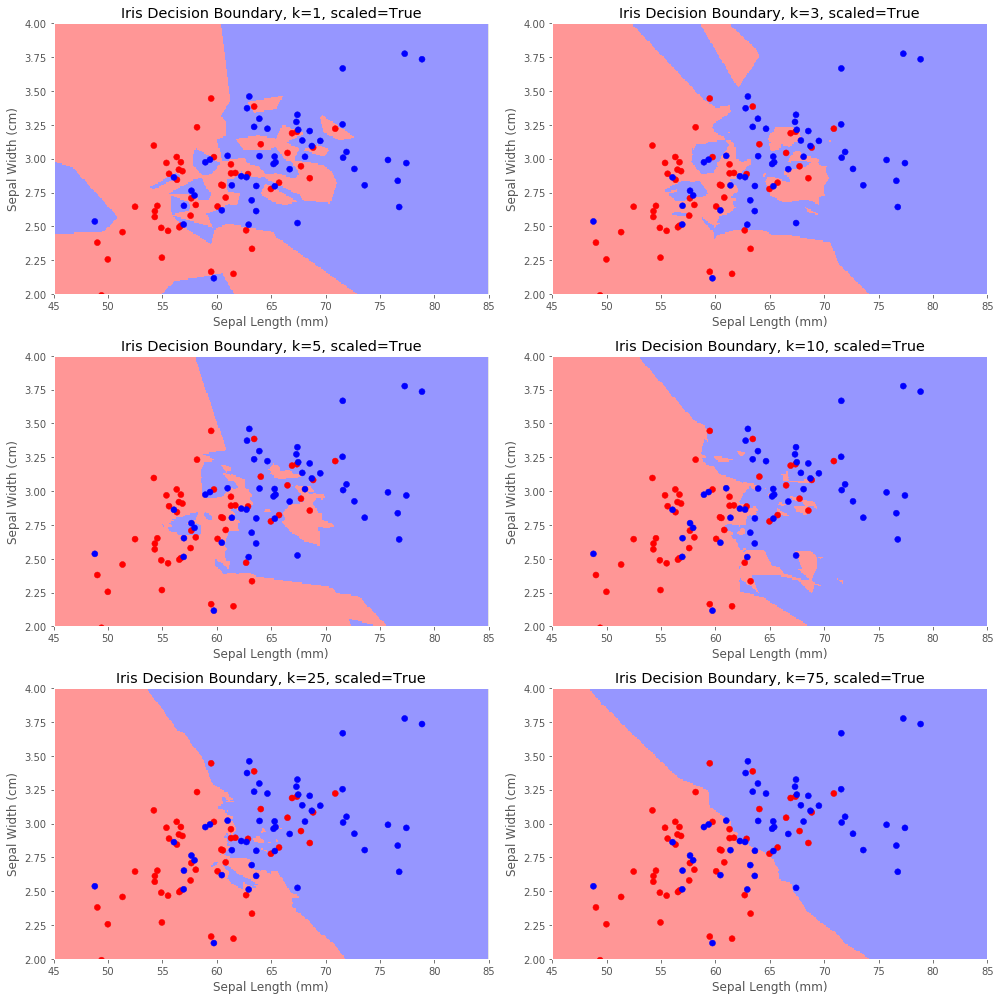

In [15]:
some_ks = [1, 3, 5, 10, 25, 75]

title="Iris Decision Boundary"
xlabel="Sepal Length (mm)"
ylabel="Sepal Width (cm)"

# Building my plot, 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
 
# Loop through the possible ks, put each decision boundary a separate axes
for k, ax in zip(some_ks, axs.flatten()):
    plot_mult_decision_boundary(ax, X, y, k=k, title = title, xlabel = xlabel, ylabel = ylabel)

# Keep things from overlapping
plt.tight_layout()
plt.show()

### Soft kNN

But a good classifier will return probabilities, not just classes. With kNN we use the number of neighbors of each class as the probability.

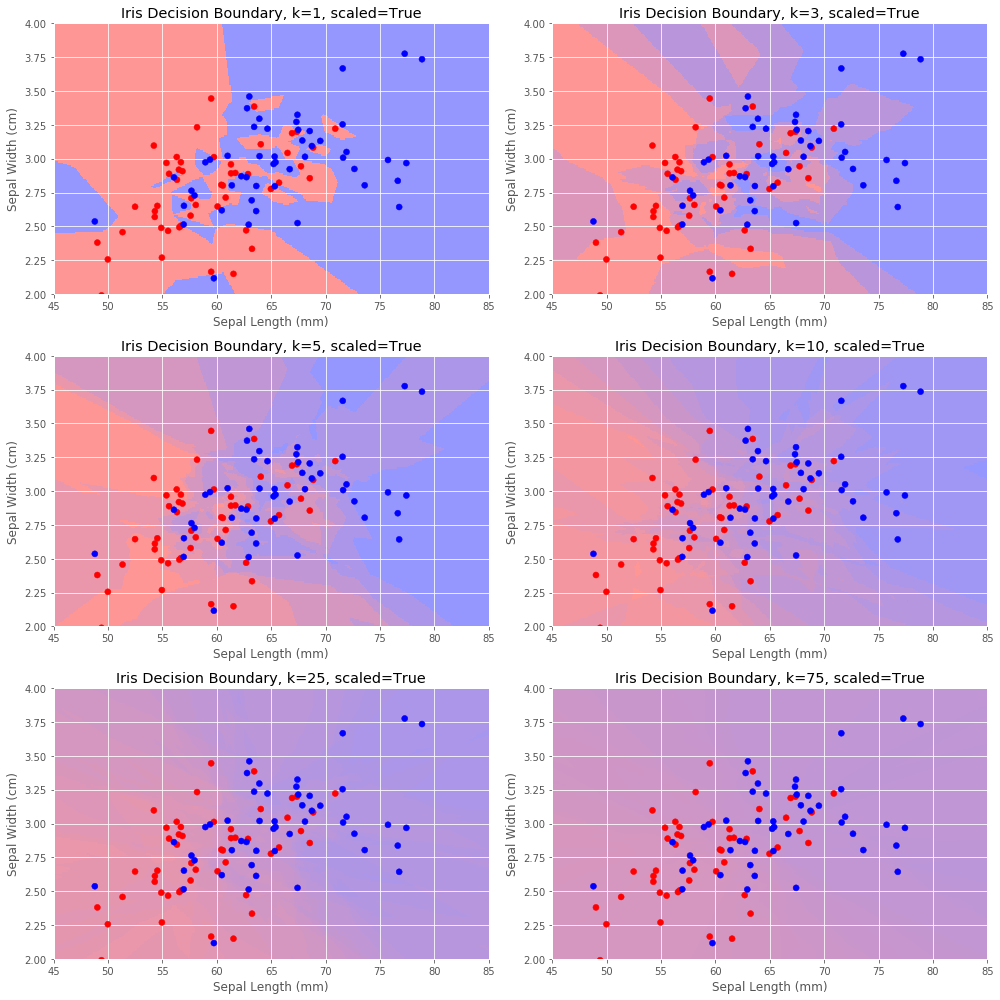

In [16]:
# Building my plot, 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
#ax.imshow()
# Loop through the possible ks, put each decision boundary a separate axes
for k, ax in zip(some_ks, axs.flatten()):
    plot_mult_decision_boundary(ax, X, y, k=k, title = title, xlabel = xlabel, ylabel = ylabel, hard_class = False)

# Keep things from overlapping
plt.tight_layout()
plt.show()

### Choosing k

How do we figure out the best value for k?

In general, a good starting point for k is $\sqrt{n}$

Let's investigate for various values.

In [17]:
def predict_sample(X, y, k, seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=seed)
    
    clf = make_pipeline(StandardScaler(), neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    clf.fit(X_train, y_train)
    
    return log_loss(clf.predict(X_test), y_test)

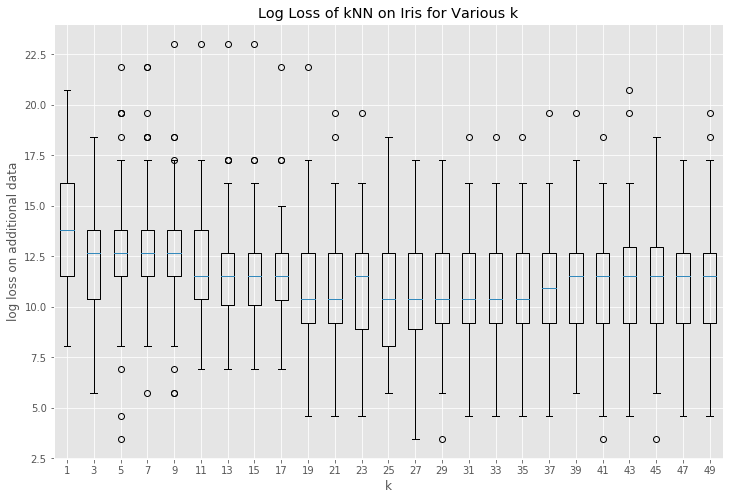

In [18]:
max_k = 50
step = 2
results = []
for k in range(1, max_k, step):
    kresults = []
    for seed in range(100):
        kresults.append(predict_sample(X, y, k, seed))
    results.append(kresults)
results = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 8))

data = np.array(results.T)
ax.boxplot(data, labels=range(1, max_k, step))
ax.set_xlabel("k")
ax.set_ylabel("log loss on additional data")
ax.set_title("Log Loss of kNN on Iris for Various k")
plt.show()

## Bias-Variance

What is bias and variance?

Class discussion: How does changing k affect each? Why?

In [19]:
# Create samples from a multivariate normal distribution
# which approximates the input data
def gen_similar_samples(X, y, n_samples = 4, sample_size = 50):
    Xs = []
    ys = []
    for _ in range(n_samples):
        Xdata = np.zeros_like(X)
        ydata = np.zeros_like(y)
        for i, value in enumerate(np.unique(y)):
            Xdata[i*sample_size:(i+1)*sample_size] = np.random.multivariate_normal(X[y == value].mean(axis = 0), 
                                                                                   np.cov(X[y == value].T), 
                                                                                   sample_size)
            ydata[i*sample_size:(i+1)*sample_size] = value
        Xs.append(Xdata)
        ys.append(ydata)
    
    return list(zip(Xs, ys))

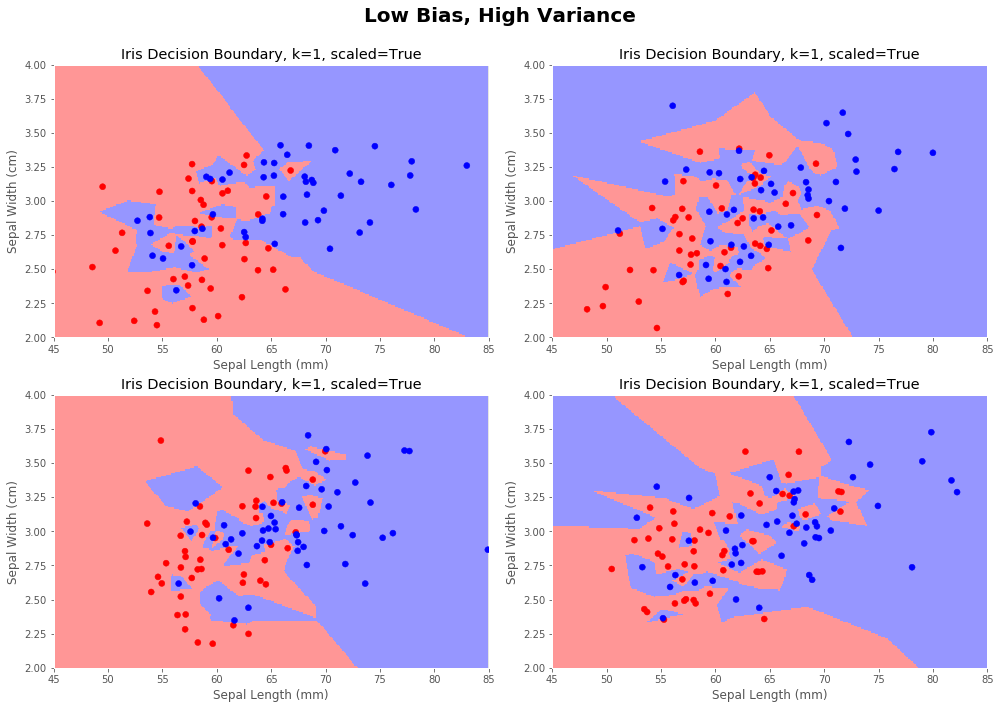

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
test_data = gen_similar_samples(X, y)
for sample, ax in zip(test_data, axs.flatten()):
    X_sample = sample[0]
    y_sample = sample[1]
    plot_mult_decision_boundary(ax, X_sample, y_sample, k=1, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
# Offset the figure title to make it look nice
plt.subplots_adjust(top=0.9)
# Set a title for the entire figure
plt.suptitle('Low Bias, High Variance', fontsize=20, weight='bold')
plt.show()

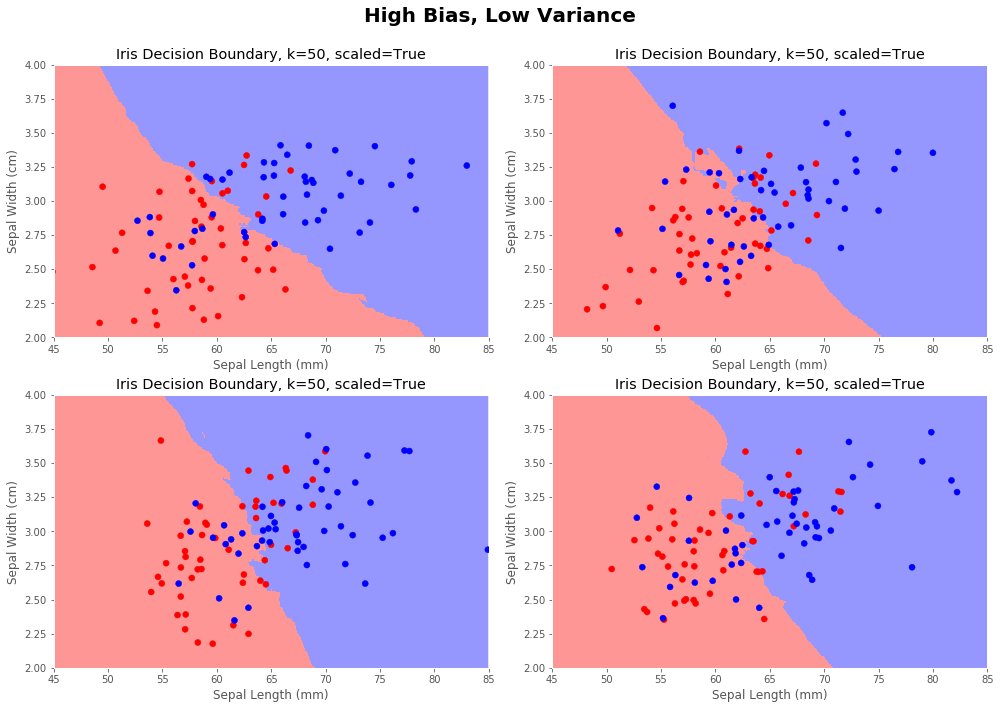

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for sample, ax in zip(test_data, axs.flatten()):
    X = sample[0]
    y = sample[1]
    plot_mult_decision_boundary(ax, X, y, k=50, title=title, xlabel=xlabel, ylabel=ylabel)
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('High Bias, Low Variance', fontsize=20, weight='bold')
plt.show()

## Scaling Could Be Important

What is going on in these plots?

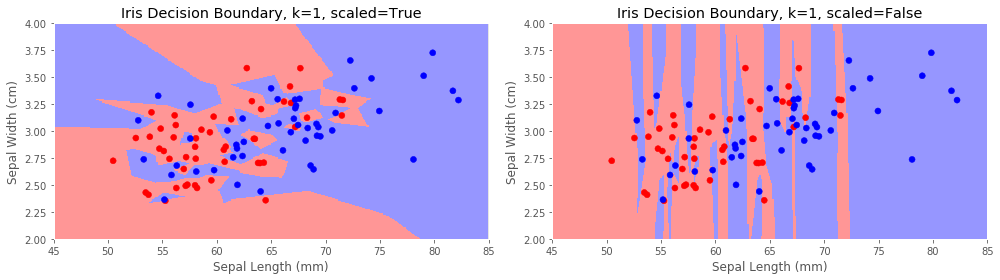

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
                        
plot_mult_decision_boundary(axs[0], X, y, k=1, title=title, xlabel=xlabel, ylabel=ylabel)
plot_mult_decision_boundary(axs[1], X, y, k=1, scaled=False, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

The general rule is that if changing the units before building the model will change the predictions, scale the data first.

## Distance Metrics

So far we've used euclidean distance for a metric; there are other choices.

### Manhattan Distance
City blocks, L1

*Manhattan* distance is the distance as measured along axes at right angles:

$$\sum_i |a_i - b_i|$$


### Euclidean Distance

Straight line, L2

*Euclidean* distance is the distance metric you're most familiar with:

$$ d(\mathbf{a}, \mathbf{b}) = ||\mathbf{a} - \mathbf{b}|| \ = \sqrt{\sum (a_i - b_i)^2} $$

### Cosine Similarity

Angle

*Cosine* similarity is another commonly used distance metric. It's measuring the angle (or rather, the cosine of the angle) between the two vectors:

$$ d(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}||  ||\mathbf{b}||} $$

Cosine similarity is appropriate for cases in which vectors in the same direction but different lengths are effectively identical (e.g., bag of words).

#### sklearn default is Minkowski (with p=2 which is really just euclidean, p=1 is manhattan)

##### Test your understanding:

Which of these people are the most similar?  Which would be the most similar by Euclidean or Manhattan distance?

| age | salary/$1000 |
|--|--|
| 25 | 20 |
| 25 | 60 |
| 25 | 65 |
| 75 | 60 |

## Curse of Dimensionality

### Perspective 1: Sample Density

Sampling density is proportional to $$N^\frac{1}{p}$$

where N is the number of samples and p is the number of dimensions.

Let's consider a data set with 100 samples that all have only one feature/predictor. But, you feel that one feature doesn't tell you enough to properly predict anything, so you set out to collect new data. The new data will have ten features/predictors for each sample. How many samples do we need to have an equally dense sample as our original dataset?

#### Original Sample

$$\begin{align}
          density & = N^\frac{1}{p} \\
          & = 100^\frac{1}{1} \\
          & = 100 
\end{align}$$

#### New Sample

$$\begin{align}
          N & = density^ p \\
          &= 100^{10} \\
          &= 100,000,000,000,000,000,000
\end{align}$$

No big, just one hundred quadrillion samples...

### Perspective 2: Loss of Locality

As we increase dimensionality, we lose the concept of locality and things get infinitely far apart. More precisely, samples that are similar no longer look similar and "closeness" becomes more arbitrary than meaningful. 

For example, in Euclidean distance we must be close in ***all*** dimensions to be considered close. If points are close in 2 of 3 dimensions, but far in the 3rd dimension then all points will be far apart.



In [ ]:
# Points drawn from a standard normal distribution 
# get further from the origin as dimensionality increases
n_points = 10000

norm_data = np.random.normal(size = (n_points, 10))
pct_close = []
for i in range(1, 11):
    value = np.mean(np.linalg.norm(norm_data[:,:i], axis = 1) < 1)
    print("{} dim: {:.2f}%".format(i, value * 100))
    pct_close.append(value)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(1, 11), pct_close)
ax.set_ylabel("Percent of points with L2 norm > 1")
ax.set_xlabel("Number of Dimensions")
ax.set_title("Ratio of points within unit sphere at increasing dimensionality");

### Regression kNN

kNN can be used used for regression as well as classification.

<img src="images/regression_knn.png" width=500 align="left"/>

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

Let the k nearest points have targets $$t_1, t_2,..., t_k$$

Predict the mean value of the targets.

### Weighted Voting

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

The ith point votes with weight of $$\frac{1}{d_i}$$

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

a = np.array([[2.1, 3.2, 2.0, 2.9, 4.1, 3.0, 4.1, 6.2, 8.4, 4.1, 4.9, 5.8, 8.1, 5.0, 7.2],
              [3.1, 3.2, 4.0, 3.9, 4.0, 5.1, 4.9, 5.0, 5.1, 6.2, 5.9, 6.1, 6.0, 7.2, 6.8]])
b = np.array([[1.2, 1.8, 3.0, 5.1, 6.1, 1.3, 2.9, 3.7, 7.1, 6.2, 6.9, 8.0, 2.7, 0.3, 1.1, 6.9, 8.1, 0.0, 2.1, 1.2, 3.3, 2.1, 2.9],
              [1.1, 1.8, 1.0, 0.9, 1.1, 2.3, 1.9, 2.3, 1.9, 3.1, 3.2, 3.0, 3.7, 4.3, 4.1, 3.9, 4.1, 5.1, 5.2, 6.3, 5.8, 7.1, 6.7]])
center = np.array([[2.5], [3.5]])
asize = 50/((a - center)**2).sum(axis=0)
bsize = 50/((b - center)**2).sum(axis=0)
ax.scatter(a[0], a[1], c='r', s=asize)
ax.scatter(b[0], b[1], c='b', s=bsize)
ax.plot(center[0], center[1], 'kx', ms=10) 
ax.add_artist(plt.Circle(center, 0.4, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 1.0, fc='None', ec='k', lw=0.5))
ax.add_artist(plt.Circle(center, 2.0, fc='None', ec='k', lw=0.5))
ax.set_aspect('equal')
plt.axis('off')
plt.show()

## Pros and Cons of kNN

**Class discussion:** what do you think they are? Why?